In [95]:
ENV["GKS_ENCODING"] = "utf-8"
using NLsolve
using Plots
using IntervalArithmetic, IntervalRootFinding
using SharedArrays

using HDF5
using LadderDGA
using Suppressor
using Logging


cfg_file = "/home/julian/Hamburg/lDGA_shift_tests/configs/config_50_100_u1_b12.toml"

io = stdout
metafmt(level::Logging.LogLevel, _module, group, id, file, line) = Logging.default_metafmt(level, nothing, group,     id, nothing, nothing)
logger = ConsoleLogger(io, Logging.Info, meta_formatter=metafmt, show_limited=true, right_justify=0)
global_logger(logger);

In [96]:
mP, sP, env, kGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file)
kG = kGrids[1]
νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Σ_loc, FUpDo, gImp, gLoc = setup_LDGA(kG, freqList, mP, sP, env);

[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
[ Info: setting usable ranges of sp and ch channel from 38:64 and 38:64 to the same range of 38:64
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(38:64) = 0.3182, χLoc_ch(38:64) = 0.1222 
└ sum χupup check (fit, tail sub, tail sub + fit, expected): 0.2201987037827738 ?≈? 0.22019870378277384 ?=? 0.22019870378277384 ?≈? 0.25"


In [97]:
# ladder quantities
bubble = calc_bubble(νGrid, GLoc_fft, kG, mP, sP);
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, kG, νGrid, sumHelper_f, mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, kG, νGrid, sumHelper_f, -mP.U, mP, sP);

# "local" correction quantities
bubbleLoc = calc_bubble(νGrid, GImp_fft, qGridLoc, mP, sP);
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, -mP.U, mP, sP);
Σ_ladderLoc = calc_Σ(locQ_sp, locQ_ch, bubbleLoc, GImp_fft, FUpDo,
                     qGridLoc, sumHelper_f, mP, sP)

Σ_ladderLoc = Σ_ladderLoc .+ mP.n * mP.U/2.0;

nlQ_sp_nλ = deepcopy(nlQ_sp);
nlQ_ch_nλ = deepcopy(nlQ_ch);

In [98]:
bubbleLoc[1,1,1]

0.004716993502033563 - 0.0im

In [73]:
λ_sp, λ_spch  = λ_correction!(impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, kG, mP, sP)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(34:68,34:68) = 34:68 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 34:68, length: 35
│ ch: 34:68, length: 35
│ usable: 34:68, length: 35
└ χch sum = 0.16076139077738255, rhs = 0.2796360167881651
┌ Info: found 
│   χ_min = -0.08768402270152302
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.08768402270152302, 1.7536804540304605]"
┌ Info: Found λsp 
└   λsp = 0.608810706895889
[ Info: new lambda correction: λsp=0.0 and λch=0.0


(0.608810706895889, [0.0, 0.0])

In [74]:
Σ_ladder = calc_Σ(nlQ_sp, nlQ_ch, bubble, GLoc_fft, FUpDo, kG, sumHelper_f, mP, sP)
Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ Σ_loc[1:size(Σ_ladder,1)];

# Preparation

For the extended $\lambda$ correction, we need to compute ladder kinetic and potential energy of the system and also compute the DMFT kinetic energy (for improved sums)

In [44]:
# renaming to make code consistent with module
kGrid = kG
iν_array = LadderDGA.iν_array
Σ_internal! = LadderDGA.Σ_internal!
subtract_tail = LadderDGA.subtract_tail
χ_λ! = LadderDGA.χ_λ!
kintegrate = LadderDGA.kintegrate
Naive = LadderDGA.Naive

# DMFT Energies
iνₙ, GImp    = LadderDGA.readGImp(env.inputDir * "/gm_wim", only_positive=true)
ϵₖ, Vₖ, μ    = LadderDGA.read_anderson_parameters(env.inputDir * "/hubb.andpar");
E_kin_ED, E_pot_ED  = LadderDGA.calc_E_ED(iνₙ[1:length(GImp)], ϵₖ, Vₖ, GImp, mP)



# Ladder Energies
Σ_hartree = mP.n * mP.U/2
E_pot_tail_c = (mP.U^2 * 0.5 * mP.n * (1-0.5*mP.n) .+ Σ_hartree .* (kGrid.ϵkGrid .+ Σ_hartree .- mP.μ))
E_pot_tail = E_pot_tail_c' ./ (iν_array(mP.β, 0:sP.n_iν-1) .^ 2)
E_pot_tail_inv = sum((mP.β/2)  .* [Σ_hartree .* ones(size(kGrid.ϵkGrid)), (-mP.β/2) .* E_pot_tail_c]);

In [45]:
function new_χ!(χ_λ::SharedArray, χ::SharedArray, λ::Float64)
    for i in eachindex(χ_λ)
        χ_λ[i] = 1.0 / ((1.0 / χ[i]) + λ)
    end
end

νZero = sP.n_iν
ωZero = sP.n_iω
ωindices = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)
iωn = 1im .* 2 .* (-sP.n_iω:sP.n_iω)[ωindices] .* π ./ mP.β
sh_f = get_sum_helper(2*sP.n_iν, sP, :f)
sh_b = LadderDGA.Naive() #get_sum_helper(length(ωindices), sP, :b)

χch_ω = kintegrate(kGrid, nlQ_ch.χ[ωindices,:], dim=2)[:,1]
χch_ω_sub = subtract_tail(χch_ω, impQ_ch.tailCoeffs[3], iωn)
χch_sum = real(sum_freq(χch_ω_sub, [1], Naive(), mP.β, corr=-impQ_ch.tailCoeffs[3]*mP.β^2/12)[1])

0.19161700186542138

# Cond 1 Test
## λsp(λch)

In [46]:
nh = ceil(Int64, size(nlQ_ch.χ,1)/2)
λch_min = -1 / maximum(real.(nlQ_ch_nλ.χ[nh,:]))
λsp_min = -1 / maximum(real.(nlQ_sp_nλ.χ[nh,:]))
println("estimated smallest vaue for λ λsp ≈ $(λsp_min), λch ≈ $(λch_min)")

estimated smallest vaue for λ λsp ≈ -0.08658444558427382, λch ≈ -2.6221866389083575


In [47]:
χch_λ = Array{Complex{Float64},2}(undef,length(ωindices), size(nlQ_sp.χ,2))
λch_range = λch_min:0.45:10
spOfch_max_nl = zeros(length(λch_range))
χupdo_ω = Array{eltype(nlQ_sp.χ),1}(undef, length(ωindices))
χupup_ω = Array{eltype(nlQ_sp.χ),1}(undef, length(ωindices))

for (λi,λchi) in enumerate(λch_range)
    χsp_λ = real.(deepcopy(nlQ_sp_nλ.χ[ωindices,:]))
    χ_λ!(χch_λ, nlQ_ch_nλ.χ[ωindices,:], λchi)
    χch_ω = kintegrate(kGrid, χch_λ, dim=2)[:,1]
    χch_ω_sub = subtract_tail(χch_ω, impQ_ch.tailCoeffs[3], iωn)
    χch_sum = real(sum_freq(χch_ω_sub, [1], Naive(), mP.β, corr=-impQ_ch.tailCoeffs[3]*mP.β^2/12)[1])
    rhs_val = (mP.n) * (1 - mP.n/2) - χch_sum
    spOfch_max_nl[λi] = LadderDGA.λsp(χsp_λ, iωn, E_kin_ED, rhs_val, kGrid, mP)
end

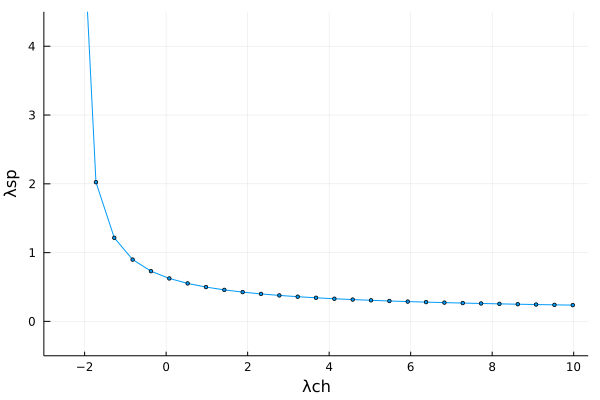

In [48]:
plot(λch_range, spOfch_max_nl, ylims=(-0.5,4.5), markershape=:circle, markersize=2, xlabel="λch", ylabel="λsp", label="")

# cond2
## λsp(λch)

In [49]:
nh = ceil(Int64, size(nlQ_ch.χ,1)/2)
λch_min = -1 / maximum(real.(nlQ_ch_nλ.χ[nh,:]))

-2.6221866389083575

In [50]:
using SharedArrays

χupdo_ω = Array{eltype(nlQ_sp.χ),1}(undef, length(ωindices))
χupup_ω = Array{eltype(nlQ_sp.χ),1}(undef, length(ωindices))
res = Array{Float64, 2}(undef, length(λch_range), 6)
nlQ_sp_i = deepcopy(nlQ_sp_nλ);
nlQ_ch_i = deepcopy(nlQ_ch_nλ);
iωn = 1im .* 2 .* (-sP.n_iω:sP.n_iω)[ωindices] .* π ./ mP.β

for i in 1:length(λch_range)
    print("\r$i of $(length(λch_range))")
    λsp_i = spOfch_max_nl[i]
    λch_i = λch_range[i]
    nlQ_sp_i.χ = LadderDGA.new_χλ(nlQ_sp_nλ.χ, λsp_i, sP)
    nlQ_sp_i.λ = λsp_i
    nlQ_ch_i.χ = LadderDGA.new_χλ(nlQ_ch_nλ.χ, λch_i, sP)
    nlQ_ch_i.λ = λch_i
    # --> sc
    Σ_ladder_i = calc_Σ(nlQ_sp_i, nlQ_ch_i, bubble, GLoc_fft, FUpDo, kG, sumHelper_f, mP, sP)
    Σ_λ = Σ_ladder_i .- Σ_ladderLoc .+ Σ_loc[1:size(Σ_ladder_i,1)];
    G_λ = LadderDGA.G_from_Σ(Σ_λ, kGrid.ϵkGrid, 0:size(Σ_ladder_i, 1)-1, mP)
    # <-- sc
    E_pot_DGA_i = LadderDGA.calc_E_pot(kGrid, LadderDGA.flatten_2D(G_λ), Σ_λ, view(E_pot_tail,1:size(Σ_ladder_i, 1),:), E_pot_tail_inv)
    for (wi,w) in enumerate(ωindices)
        χupup_ω[wi] = kintegrate(kGrid, nlQ_ch_i.χ[w,:] .+ nlQ_sp_i.χ[w,:])[1] / 2
        χupdo_ω[wi] = kintegrate(kGrid, nlQ_ch_i.χ[w,:] .- nlQ_sp_i.χ[w,:])[1] / 2
    end
    χupup_ω = subtract_tail(χupup_ω, impQ_ch.tailCoeffs[3], iωn)
    lhs_c1 = real(sum_freq(χupup_ω, [1], LadderDGA.Naive(), mP.β, corr=-impQ_sp.tailCoeffs[3]*mP.β^2/12)[1])
    lhs_c2 = real(sum_freq(χupdo_ω, [1], LadderDGA.Naive(), mP.β)[1])
    rhs_c1 = mP.n/2 * (1 - mP.n/2)
    rhs_c2 = E_pot_DGA_i/mP.U - (mP.n/2) * (mP.n/2)
    res[i,:] = [λsp_i λch_i lhs_c1 rhs_c1 lhs_c2 rhs_c2]
end

29 of 29

In [15]:
E_kin_DGA, E_pot_DGA = LadderDGA.calc_E(Σ_ladder_corrected, kGrid, mP, sP)

LoadError: UndefVarError: Σ_ladder_corrected not defined

In [16]:
G_λ = LadderDGA.G_from_Σ(Σ_ladder_corrected, kGrid.ϵkGrid, 0:size(Σ_ladder_corrected, 1)-1, mP)

E_pot_DGA_i = LadderDGA.calc_E_pot_νn(kGrid, LadderDGA.flatten_2D(G_λ), Σ_ladder_corrected, view(E_pot_tail,1:size(Σ_ladder_corrected, 1),:), E_pot_tail_inv)


LoadError: UndefVarError: kGrid not defined

In [17]:
Σ_in = Σ_ladder_corrected .+ mP.n * mP.U/2
E_pot = LadderDGA.flatten_2D(LadderDGA.G_from_Σ(Σ_in, kGrid.ϵkGrid, 0:73, mP)) .* Σ_in
E_pot_list = [kintegrate(kGrid, 2 .* sum(E_pot[1:i,:], dims=[1])[1,:] .+ E_pot_tail_inv) for i in 1:74]

LoadError: UndefVarError: mP not defined

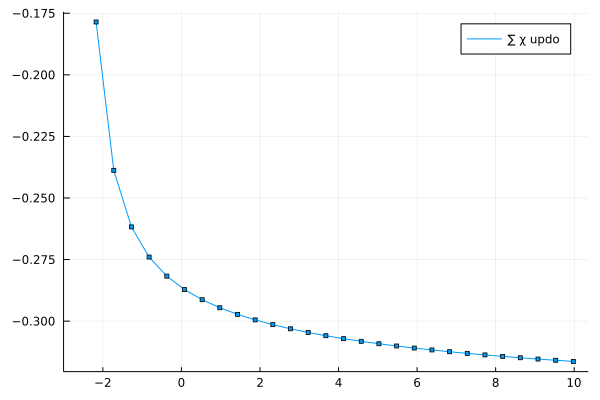

In [57]:
plot(λch_range, res[:,5] .- (res[:,6]./mP.β), markershape=:square, markersize=2, label="∑ χ updo")
#plot!(λch_range,, markershape=:square, markersize=2, label="G ⋆ Σ")
#plot!(λch_range, spOfch_max_nl, ylims=(-5,5), markershape=:circle, markersize=2, xlabel="λch", ylabel="λsp", label="")

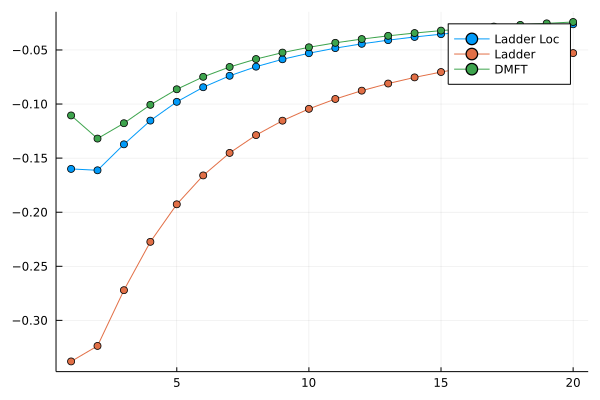

In [81]:
plot(imag(Σ_ladderLoc[1:20]), label="Ladder Loc",markershape=:circle)
plot!(imag(Σ_ladder_corrected[1:20,1]), label="Ladder",markershape=:circle)
plot!(imag(Σ_loc[1:20]), label="DMFT",markershape=:circle)

In [85]:
using JLD2
f = jldopen("/home/julian/Hamburg/lDGA_shift_tests/data/50_100_s1_b12_u1.0/ED_out.jld2")

JLDFile /home/julian/Hamburg/lDGA_shift_tests/data/50_100_s1_b12_u1.0/ED_out.jld2 (read-only)
 ├─🔢 Γch
 ├─🔢 Γsp
 ├─🔢 χDMFTch
 ├─🔢 χDMFTsp
 ├─🔢 gImp
 └─🔢 g0

In [86]:
f["g0"]

302-element Vector{ComplexF64}:
    0.8656991154798109 - 0.9909405998429446im
   0.40615898770471254 - 0.8045824085301071im
    0.2096225972106768 - 0.612620242205564im
    0.1231571402358523 - 0.4807770785724203im
   0.07975988468917723 - 0.3913542259548549im
   0.05543624698070286 - 0.3283280622823767im
  0.040601619278952325 - 0.28205451081277116im
   0.03094713343816578 - 0.24685327992208636im
   0.02433615018568519 - 0.2192716401304787im
  0.019621579152238985 - 0.19712471163212997im
  0.016146441227305536 - 0.17897534715793748im
  0.013513879829660059 - 0.1638448495109615im
  0.011473282882668231 - 0.15104611727956047im
                       ⋮
 2.1610582034917365e-5 - 0.006574244979659553im
  2.146256953153116e-5 - 0.006551692790506239im
 2.1316072444129563e-5 - 0.0065292947944869725im
 2.1171070156056513e-5 - 0.0065070494156646355im
 2.1027542399957675e-5 - 0.0064849550994880425im
 2.0885469250865864e-5 - 0.006463010312455481im
 2.0744831119256194e-5 - 0.006441213541755484im
 2

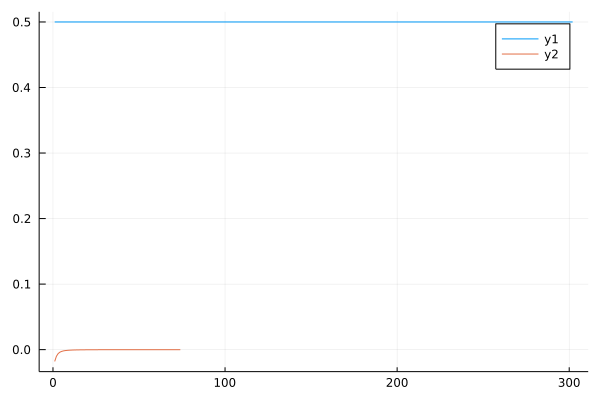

In [76]:
plot(real(Σ_loc))
plot!(real(Σ_ladder_corrected[:,1]))

# extended Lambda test

# Condition 2

In [20]:
println(minimum((lhs_overview .- rhs_overview)))
writedlm("cond2_lhs.csv",  lhs_overview , ' ')
writedlm("cond2_rhs.csv",  rhs_overview , ' ')
plot(heatmap(λch_range_c2, λsp_range_c2, (lhs_overview .- rhs_overview), xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", title=L"|\sum \chi_\mathrm{m}(\omega,q) -  U (G^\lambda \star \Sigma^\lambda + \frac{n^2}{4})|"), 
    heatmap(λch_range_c2, λsp_range_c2, rhs_overview, xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", title=L"U (G^\lambda \star \Sigma^\lambda + \frac{n^2}{4})"), 
    heatmap(λch_range_c2, λsp_range_c2, lhs_overview, xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", title=L"\sum \chi_\mathrm{m}(\omega,q)"),
    plot(λch_range[9:end-82], spOfch_max_nl[2,9:end-82], title=L"\sum \chi_\mathrm{d}(\omega, q) \stackrel{!}{=} \frac{n}{2} (1 - \frac{n}{2})", label=L"\lambda_\mathrm{sp}(\lambda_\mathrm{ch})", xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", markershape=:hexagon, markersize=2.8),
    layout=(2,2),size=(900,800))


LoadError: UndefVarError: lhs_overview not defined

In [21]:
println(minimum((lhs_overview2 .+ rhs_overview2)))
writedlm("cond2_lhs2.csv",  lhs_overview2, ' ')
writedlm("cond2_rhs2.csv",  rhs_overview2, ' ')
plot(heatmap(λch_range_c22, λsp_range_c22, (lhs_overview2 .- rhs_overview2), xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", title=L"|\sum \chi_\mathrm{m}(\omega,q) - G^\lambda \star \Sigma^\lambda|"), 
    heatmap(λch_range_c22, λsp_range_c22, rhs_overview2, xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", title=L"G^\lambda \star \Sigma^\lambda"), 
    heatmap(λch_range_c22, λsp_range_c22, lhs_overview2, xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", title=L"\sum \chi_\mathrm{m}(\omega,q)"),
    plot(λch_range[9:end-82], spOfch_max_nl[2,9:end-82], title=L"\sum \chi_\mathrm{d}(\omega, q) \stackrel{!}{=} \frac{n}{2} (1 - \frac{n}{2})", label=L"\lambda_\mathrm{sp}(\lambda_\mathrm{ch})", xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", markershape=:hexagon, markersize=2.8),
    layout=(2,2),size=(900,800))


LoadError: UndefVarError: lhs_overview2 not defined

# Both conditions

In [22]:
mP = LadderDGA.modelParams
sP = LadderDGA.simParams
nc = [0,1,2,3]
NW = floor(Int64, length(usable_ω)/2)
ωmin = 1
ωmax = NW 
coeffs = collect(0:3)
Wω = LadderDGA.build_weights(ωmin, ωmax, coeffs)
println("building  weight matrix from $ωmin to $ωmax with coefficients $(coeffs)")
include("src/ConvergenceAcc.jl")
#Shanks.shanks(E_Pot, csum_inp=true) 

testf_c2(λspi , λchi) = LadderDGA.calc_E_pot_cond(λspi , λchi, nlQ_sp, nlQ_ch, bubble, 
                         LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                         LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                         LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                         mP, sP, sP.tail_corrected);
function cond_both_nc!(F, λ)
    testf!(λ) = construct_f(λ[1],λchi, rχsp, rχch, mode=m, rhs=rhs_val)
    testdf!(λ) = construct_df(λ[1], λchi, rχsp, rχch, mode=m, rhs=rhs_val);
    Σ_ladder2, lhs_c2, E_pot_DGA = testf_c2(λ[1], λ[2])
    χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ), λ[1])
    χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ), λ[2])
    χupup = LadderDGA.sum_q(χch_λ[usable_ω,:].+ χsp_λ[usable_ω,:], LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
    nwh = ceil(Int64, size(χsp_λ,1)/2)
    penalty = sum(abs.(χsp_λ[nwh,(χsp_λ[nwh,:] .< 0)])) + sum(abs.(χch_λ[nwh,(χch_λ[nwh,:] .< 0)])) 
    #penalty2 = length(χch_λ[nwh,((χch_λ[nwh,:] .< 0.01) .& (χch_λ[nwh,:] .>= 0.0))])
    tmp =  real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1]) 
    #tmp += -penalty
    lhs_c1 = (mP.n/2) * (1 - mP.n/2)
    println("calling for λ=$λ, E_pot=$(E_pot_DGA), penalty = $penalty")
    F[1] = penalty > 0 ? penalty : tmp - lhs_c1
    F[2] = (lhs_c2) - E_pot_DGA# - penalty
end

function cond_both_c!(F, λ)
    Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(λ[1], λ[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=true);
    χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ), λ[1])
    χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ), λ[2])
    χupup = LadderDGA.sum_q(χch_λ[usable_ω,:].+ χsp_λ[usable_ω,:], LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
    nwh = ceil(Int64, size(χsp_λ,1)/2)
    penalty = sum(abs.(χsp_λ[nwh,(χsp_λ[nwh,:] .< 0)])) + sum(abs.(χch_λ[nwh,(χch_λ[nwh,:] .< 0)])) 
    #penalty2 = length(χch_λ[nwh,((χch_λ[nwh,:] .< 0.01) .& (χch_λ[nwh,:] .>= 0.0))])
    tmp =  real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1]) 
    #tmp += -penalty
    lhs_c1 = mP.n/2 * (1 - mP.n/2)
    println("calling for λ=$(round.(λ,digits=2)), E_pot=$(E_pot_DGA), res = $(abs(tmp - lhs_c1) + abs(E_pot_DGA + (lhs_c2))), penalty = $penalty")
    F[1] = penalty > 0 ? penalty : tmp - lhs_c1
    F[2] = (lhs_c2) - E_pot_DGA
    #F[3] = mP.n - sum(Gμλ)
end

LoadError: UndefVarError: modelParams not defined

In [23]:
using LaTeXStrings
χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ[usable_ω,:]), res_nc.zero[1])
χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ[usable_ω,:]), res_nc.zero[2])
χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
χupdo = LadderDGA.sum_q(χch_λ .- χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
rhs_c1 = real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1])  
rhs_c2 = mP.U * real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω)[1])  + mP.n^2/4
lhs_c1 = mP.n/2 * (1 - mP.n/2)
Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(res_nc.zero[1], res_nc.zero[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=false);
E_Kin, E_Pot = LadderDGA.calc_E(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);


l = @layout [A{0.01h}; 
             [grid(1,2)
              b{0.3h}]]
nhi = 20
xarr = usable_ω .- ceil(Int64, size(bubble,1)/2)
title = plot(title = L"U=%$(mP.U), \beta=%$(mP.β)", grid = false, showaxis = false, bottom_margin = -50Plots.px)
p1 = plot(xarr, χsp_λ[:,1], legend = true, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{sp}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:circle, markersize=2)
annotate_y_pos = 0.7*maximum([maximum(χsp_λ[:,1]), maximum(χsp_λ[:,nhi]), maximum(χsp_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{sp} = %$(round(res_nc.zero[1],digits=3))", :right, 10))

    
p2 = plot(xarr, χch_λ[:,1], legend = false, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{ch}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:hexagon, markersize=2)
annotate_y_pos = 0.75*maximum([maximum(χch_λ[:,1]), maximum(χch_λ[:,nhi]), maximum(χch_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{ch} = %$(round(res_nc.zero[2],digits=3))", :right, 10))


p3 = plot(E_Pot, xlabel=L"\nu_n", label=L"\qquad\qquad\;\;\; G^\lambda \star \Sigma^\lambda = %$(round(E_Pot[end], digits=6))", markershape=:hexagon, markersize=2,legend=:bottomright, legendfontsize=9)
plot!([rhs_c2], seriestype = :hline, label=L"\frac{1}{\beta N_k} \sum_{\omega,q} \chi_\mathrm{up, do}\quad\, = %$(round(rhs_c2, digits=6))")
plot!([E_Pot[end]], seriestype = :hline, linestyle=:dash, label=L"\mathrm{\;\;\;naive\;E}_\mathrm{pot, LDGA} = %$(round(E_pot_DGA, digits=6))")
annotate_y_pos = (0.3*(maximum(E_Pot) - minimum(E_Pot)) + minimum(E_Pot))
annotate!(0.2*length(E_Pot), annotate_y_pos, text(L"\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} = %$(round(rhs_c1,digits=14)) \stackrel{!}{=} \frac{n}{2} (1-\frac{n}{2}) = %$(mP.n/2 *(1 - mP.n/2))", :left, 10))

plot(title, p1, p2, p3, layout = l, size=(1000,800))
#savefig("cond_solution_tc_test_b15U2.pdf")

LoadError: UndefVarError: nlQ_sp not defined

In [24]:
using LaTeXStrings

χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ[usable_ω,:]), res_nc.zero[1])
χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ[usable_ω,:]), res_nc.zero[2])
χsp_λ_old = LadderDGA.χ_λ(real.(nlQ_sp.χ[usable_ω,:]),0.050817859568877091)
χch_λ_old = LadderDGA.χ_λ(real.(nlQ_ch.χ[usable_ω,:]), 0.0)
χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
χupdo = LadderDGA.sum_q(χch_λ .- χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
rhs_c1 = real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1])  
rhs_c2 = mP.U * real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω)[1])  + mP.n^2/4
lhs_c1 = mP.n/2 * (1 - mP.n/2)
Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(res_nc.zero[1], res_nc.zero[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=false);
E_Kin, E_Pot = LadderDGA.calc_E(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);
E_Kin_naive, E_Pot_naive = calc_E_notail(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);
l = @layout [A{0.025h}; 
             grid(1,2)]
nhi = 20
xarr = usable_ω .- ceil(Int64, size(bubble,1)/2)
title = plot(title = L"U=%$(mP.U), \beta=%$(mP.β)", grid = false, showaxis = false, bottom_margin = -50Plots.px, titlefontsize=18)
p1 = plot(xarr, χsp_λ_old[:,end], label=L"\mathrm{Old\;Method:}\;\; \lambda_\mathrm{sp} = 0.051", markershape=:circle, markersize=3, markerstrokewidth=0.6)
plot!(xarr, χsp_λ[:,end], color=:orange, legend = :outertop, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{sp}}", label=L"\mathrm{New\;Method:}\; \lambda_\mathrm{sp} = %$(round(res_nc.zero[1],digits=3))", markershape=:hexagon, markerstrokewidth=0.6, markersize=3,
    xtickfontsize=12,ytickfontsize=12,legendfontsize=12,xguidefontsize=16,yguidefontsize=16, margin=4Plots.mm)
#plot!(xarr, χsp_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:circle, markersize=2)
#p1 = plot(xarr, χsp_λ[:,end], label=L"q=$(\pi,\pi,\pi)", markershape=:circle, markersize=2)
annotate_y_pos = 0.7*maximum([maximum(χsp_λ[:,1]), maximum(χsp_λ[:,nhi]), maximum(χsp_λ[:,end])])
#annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{sp} = %$(round(res_nc.zero[1],digits=3))", :right, 10))
annotate!(xarr[end-2], annotate_y_pos, text(L"\vec{q}=(\pi,\pi,\pi)", :right, 16))
    
p2 = plot(xarr, χch_λ_old[:,end], label=L"\mathrm{Old\;Method:}\;\; \lambda_\mathrm{ch} = 0", markershape=:circle, markersize=3, markerstrokewidth=0.6)
plot!(xarr, χch_λ[:,end], color=:orange, legend = :outertop, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{ch}}", label=L"\mathrm{New\;Method:}\; \lambda_\mathrm{ch} = %$(round(res_nc.zero[2],digits=3))", markershape=:hexagon, markersize=3, markerstrokewidth=0.6,xtickfontsize=12,ytickfontsize=12,legendfontsize=12,xguidefontsize=16,yguidefontsize=16)
#plot!(xarr, χch_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:hexagon, markersize=2)
#plot!(xarr, χch_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:hexagon, markersize=2)
annotate_y_pos = 0.75*maximum([maximum(χch_λ[:,1]), maximum(χch_λ[:,nhi]), maximum(χch_λ[:,end])])
#annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{ch} = %$(round(res_nc.zero[2],digits=3))", :right, 10))
annotate!(xarr[end-2], annotate_y_pos, text(L"\vec{q}=(\pi,\pi,\pi)", :right, 16))



plot(title, p1, p2, layout = l, size=(1200,600))
#savefig("cond_solution_tc_test_b25U1.pdf")

LoadError: UndefVarError: nlQ_sp not defined

In [25]:
l2 = @layout [A{0.025h}; 
             grid(2,1)]

t = [real(mP.U * real(LadderDGA.sum_freq(χupdo[i+1:(end-i)], [1], true, mP.β, weights=LadderDGA.build_weights(1, floor(Int64, size(χupup[i+1:(end-i)], 1)/2), collect(0:3)))[1])  + mP.n^2/4) for i in 8:-1:0]

nanline = repeat([NaN], length(E_Pot))
p3 = plot(E_Pot_naive, xlabel=L"\nu_\mathrm{max}", 
    label=L"\;\;\;\frac{1}{\beta N_k}\sum_{\nu,q} G^\lambda \star \Sigma^\lambda\, = %$(round(E_Pot_naive[end], digits=6))",
    markershape=:hexagon, markersize=2, markerstrokewidth=0.4,legend=:bottomright, margin=1Plots.mm,
    xtickfontsize=12,ytickfontsize=12, legendfontsize=12,xguidefontsize=16,yguidefontsize=16)
plot!(nanline, label=" ", alpha= 0.0)
#[rhs_c2], seriestype = :hline
plot!(nh-9:nh-1,t,markershape=:hexagon, color=:orange, markersize=4, markerstrokewidth=0.4, label=L"\quad\;\mathrm{SumFit}_{\omega}[\chi_\mathrm{up, do}] = %$(round(rhs_c2, digits=6))")
plot!([rhs_c2], seriestype = :hline, label=nothing, color=:orange)
plot!(nanline, label=" ", alpha= 0.0)
plot!([E_Pot], markershape=:hexagon, markersize=2, markerstrokewidth=0.4, 
    label=L"{\mathrm{SumFit}_{\nu}[G^\lambda \star \Sigma^\lambda]\, = %$(round(E_Pot[end], digits=6))}")

naive_chiupup_sum = (χupup[nh] .+ 2 .* cumsum(χupup[nh+1:end])) ./ mP.β
tt = [real(LadderDGA.sum_freq(χupup[i+1:(end-i)], [1], true, mP.β, weights=LadderDGA.build_weights(1, floor(Int64, size(χupup[i+1:(end-i)], 1)/2), collect(0:3)))[1]) for i in 8:-1:0]
real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1]) 

nanline = repeat([NaN], length(tt))
p4 = plot(1:nh-1,naive_chiupup_sum, xlabel=L"\omega_\mathrm{max}", 
    label=L"\;\;\;\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} =   %$(round(naive_chiupup_sum[end],digits=4))", xticks=collect(1:nh-1), margin=5Plots.mm,
    markershape=:hexagon, markersize=2, markerstrokewidth=0.4,legend=:bottomright,xtickfontsize=12,ytickfontsize=12, legendfontsize=12,xguidefontsize=16,yguidefontsize=16)
plot!(nanline, label=" ", alpha= 0.0)
plot!(nh-9:nh-1,tt,markershape=:hexagon, markersize=2, markerstrokewidth=0.4, color=:orange, label=L"\mathrm{SumFit}_{\omega}[\chi_\mathrm{up, up}] = %$(round(rhs_c1,digits=4))")
plot!(nanline, label=" ", alpha= 0.0)

plot!([0.25], seriestype = :hline, color=:green, label=L"\qquad\;\frac{n}{2}\left({1-\frac{n}{2}}\right) = \frac{1}{4}")
annotate_y_pos = (0.08*(maximum(χupup) - minimum(χupup)) + minimum(χupup))
#annotate!(0.3*length(1:nh-1), annotate_y_pos, text(L"\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} = %$(round(rhs_c1,digits=12)) \stackrel{!}{=} \frac{n}{2} (1-\frac{n}{2}) = %$(mP.n/2 *(1 - mP.n/2))", :left, 14))

plot(title, p3, p4, layout = l2, size=(1200,600))
#savefig("cond_solution_tc_test_b25U1_2.pdf")

LoadError: UndefVarError: mP not defined

In [26]:
using LaTeXStrings
usable_ω = ωindices
lsp_zero = 0.04856121321074435#res_c.zero[1]
lch_zero = 0.1292099471786603#res_c.zero[2]
χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ[usable_ω,:]), lsp_zero)
χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ[usable_ω,:]), lch_zero)
χupup = LadderDGA.kintegrate(qG, χch_λ .+ χsp_λ, dim=2)[:,1] ./ 2
χupdo = LadderDGA.kintegrate(qG, χch_λ .- χsp_λ, dim=2)[:,1] ./ 2
rhs_c1 = real(LadderDGA.sum_freq(χupup, [1], Naive(), mP.β)[1])  
rhs_c2 = mP.U * real(LadderDGA.sum_freq(χupdo, [1], Naive(), mP.β)[1])  + mP.n^2/4
lhs_c1 = (mP.n/2) * (1 - mP.n/2)
Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(lsp_zero, lch_zero, nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=true);
E_Kin, E_Pot = LadderDGA.calc_E(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);

l = @layout [A{0.01h}; 
             [grid(1,2)
              b{0.3h}]]
nhi = 20
xarr = usable_ω .- ceil(Int64, size(bubble,1)/2)
title = plot(title = L"U=%$(mP.U), \beta=%$(mP.β), \mathrm{E}_\mathrm{pot} \mathrm{\;extrapolated}", grid = false, showaxis = false, bottom_margin = -50Plots.px)
p1 = plot(xarr, χsp_λ[:,1], legend = true, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{sp}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:circle, markersize=2)
annotate_y_pos = 0.7*maximum([maximum(χsp_λ[:,1]), maximum(χsp_λ[:,nhi]), maximum(χsp_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{sp} = %$(round(lsp_zero,digits=3))", :right, 10))
    
p2 = plot(xarr, χch_λ[:,1], legend = false, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{ch}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:hexagon, markersize=2)
annotate_y_pos = 0.75*maximum([maximum(χch_λ[:,1]), maximum(χch_λ[:,nhi]), maximum(χch_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{ch} = %$(round(lch_zero,digits=3))", :right, 10))


p3 = plot(E_Pot, xlabel=L"\nu_n", label=L"\qquad\qquad\;\;\; G^\lambda \star \Sigma^\lambda = %$(round(E_Pot[end], digits=6))", markershape=:hexagon, markersize=2,legend=:bottomright, legendfontsize=10)
plot!(repeat([rhs_c2], length(E_Pot)), label=L"\frac{1}{\beta N_k} \sum_{\omega,q} \chi_\mathrm{up, do}\quad\, = %$(round(rhs_c2, digits=6))")
#plot!([E_pot_DGA[1]], seriestype = :hline, linestyle=:dash, label=L"\qquad\qquad\mathrm{E}_\mathrm{pot, LDGA} = %$(round(E_pot_DGA[1], digits=6))")
plot!([E_Pot[end]], seriestype = :hline, linestyle=:dash, label=L"\mathrm{\;\;\;naive\;E}_\mathrm{pot, LDGA} = %$(round(E_pot_DGA[1], digits=6))")
annotate_y_pos = (0.3*(maximum(E_Pot) - minimum(E_Pot)) + minimum(E_Pot))
annotate!(0.2*length(E_Pot), annotate_y_pos, text(L"\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} = %$(round(rhs_c1,digits=14)) \stackrel{!}{=} \frac{n}{2} (1-\frac{n}{2}) = %$(mP.n/2 *(1 - mP.n/2))", :left, 10))

plot(title, p1, p2, p3, layout = l, size=(1000,800))
savefig("cond_solution_tc_test_b25U1.pdf")

LoadError: UndefVarError: ωindices not defined

# q-dependent correction

## Fit and subtract old $\frac{1}{i\omega^2}$ tail

In [27]:
using LsqFit
tail_func(iωn, c)  = sum([c[n] ./ (iωn .^ (n-1)) for n in 1:length(c)])
tail_func_n0(iωn, c)  = sum([c[n] ./ (iωn .^ (n)) for n in 1:length(c)])
tail_func_real(iωn, c)  = real(sum([c[n] ./ (iωn .^ (n-1)) for n in 1:length(c)]))
tail_func_real_n0(iωn, c)  = real(sum([c[n] ./ (iωn .^ (n)) for n in 1:length(c)]))

tail_func(iωn, c) = sum([c[n] ./ (iωn .^ (n-1)) for n in 1:length(c)])
tail_func_r(iωn, c) = real(sum([c[n] ./ (iωn .^ (n-1)) for n in 1:length(c)]))
tail_func_0(iωn, c) = c ./ (iωn .^ 0)
tail_func_1(iωn, c) = c ./ (iωn .^ 1)
tail_func_2(iωn, c) = real.(c ./ (iωn .^ 2))

rχsp = real.(nlQ_sp_nλ.χ)
rχch = real.(nlQ_ch_nλ.χ)
rχupup = 0.5 .* real.(rχsp .+ rχch)

nh   = ceil(Int64, size(rχsp,1)/2) + 20
ωindices_q = nh:last(ωindices)
min_ω = 1
qind = 1
p2 = [1.0]
p0_2 = [0.0, 0.0, 1.0]
p0_4 = [0.0, 0.0, 1.0, 0.0, 1.0]
p1_2 = [0.0, 1.0]
p1_4 = [0.0, 1.0, 0.0, 1.0]
iω_arr = LadderDGA.iω_array(mP.β, -sP.n_iω:sP.n_iω)[ωindices_q];

LoadError: UndefVarError: nlQ_sp_nλ not defined

In [28]:
#Tests for setup below

fit_only2 = curve_fit(tail_func_2, iω_arr, rχsp[ωindices_q,1], p2)   
fit_0to2 = curve_fit(tail_func_real, iω_arr, rχsp[ωindices_q,1], p0_2); 
println("Results for fit of χsp(ω, q=(0,0,0)) fit:")
println("Fit only 2 converged = $(fit_only2.converged) with result $(round.(fit_only2.param,digits=5)).\nFit 0 to 4 converged = $(fit_0to2.converged) with result $(round.(fit_0to2.param,digits=5))")

LoadError: UndefVarError: rχsp not defined

## Investigation of different tail coefficients

TODO: investigate effect between real part fitting and full fit. For now only real parts are fitted!

In the following we investigate the fitting tails of the form:
 - $\frac{c_2}{i \omega_n^2}$
 - $\sum_{l=0}^2 \frac{c_l}{i \omega_n^l}$
 - $\sum_{l=0}^4 \frac{c_l}{i \omega_n^l}$
 - $\sum_{l=1}^2 \frac{c_l}{i \omega_n^l}$
 - $\sum_{l=1}^4 \frac{c_l}{i \omega_n^l}$
 
### Plots

The plots show the fit coeffcient $c_2$ for all 5 different methods and for $\chi_\text{sp}$, $\chi_\text{ch}$, $\chi_\text{upup}$. Since the only contribution for the second tail coefficient comes from $\chi_\text{upup}$, all three solutions are supposed to be similar. 

### Remarks: numerics

- When also fitting the $c_4$ coefficient, the tail behavior of $\chi_\text{updo}$ participates and we expect to see a difference between $\chi_\text{sp}$ and $\chi_\text{ch}$. Observing no difference between both suggests insufficient data. 

- A large difference between the $c_2$ and $c\text{0-2}$ fits also suggests faulty input. This is due to the fact, that $c_0$ and $c_1$ must be 0 (since the sum over $\chi_r$ is real and converges)

- The solution will strongly depend on the first bosonic Matsubara frequency used (i.e. if hte fit starts are $i\omega_1$ or $i\omega_{10}$. Setting the `nh` parameter above will generate data for different starting values.

In [29]:
tail_sp = Array{Float64,2}(undef, size(rχsp,2),5)
tail_ch = Array{Float64,2}(undef, size(rχsp,2),5)
tail_upup = Array{Float64,2}(undef, size(rχsp,2),5)

for qi in 1:size(tail_sp,1)
    fit = curve_fit(tail_func_2, iω_arr, rχsp[ωindices_q,qi], p2);
    tail_sp[qi,1] = fit.param[1]
    fit = curve_fit(tail_func_2, iω_arr, rχch[ωindices_q,qi], p2);
    tail_ch[qi,1] = fit.param[1]
    fit = curve_fit(tail_func_2, iω_arr, rχupup[ωindices_q,qi], p2);
    tail_upup[qi,1] = fit.param[1]
    
    fit = curve_fit(tail_func_real, iω_arr, rχsp[ωindices_q,qi], p0_2);
    tail_sp[qi,2] = fit.param[3]
    fit = curve_fit(tail_func_real, iω_arr, rχch[ωindices_q,qi], p0_2);
    tail_ch[qi,2] = fit.param[3]
    fit = curve_fit(tail_func_real, iω_arr, rχupup[ωindices_q,qi], p0_2);
    tail_upup[qi,2] = fit.param[3]
    
    fit = curve_fit(tail_func_real, iω_arr, rχsp[ωindices_q,qi], p0_4);
    tail_sp[qi,3] = fit.param[3]
    fit = curve_fit(tail_func_real, iω_arr, rχch[ωindices_q,qi], p0_4);
    tail_ch[qi,3] = fit.param[3]
    fit = curve_fit(tail_func_real, iω_arr, rχupup[ωindices_q,qi], p0_4);
    tail_upup[qi,3] = fit.param[3]
    
    fit = curve_fit(tail_func_real_n0, iω_arr, rχsp[ωindices_q,qi], p1_2);
    tail_sp[qi,4] = fit.param[2]
    fit = curve_fit(tail_func_real_n0, iω_arr, rχch[ωindices_q,qi], p1_2);
    tail_ch[qi,4] = fit.param[2]
    fit = curve_fit(tail_func_real_n0, iω_arr, rχupup[ωindices_q,qi], p1_2);
    tail_upup[qi,4] = fit.param[2]
    
    fit = curve_fit(tail_func_real_n0, iω_arr, rχsp[ωindices_q,qi], p1_4);
    tail_sp[qi,5] = fit.param[2]
    fit = curve_fit(tail_func_real_n0, iω_arr, rχch[ωindices_q,qi], p1_4);
    tail_ch[qi,5] = fit.param[2]
    fit = curve_fit(tail_func_real_n0, iω_arr, rχupup[ωindices_q,qi], p1_4);
    tail_upup[qi,5] = fit.param[2]
end

LoadError: UndefVarError: rχsp not defined

In [30]:
plot(tail_sp[1,:], markershape=:square, markersize=2, label="χsp", xticks = ([1,2,3,4,5],["c2", "c0-2", "c0-4", "c1-2", "c1-4"]), ylabel=L"c_2(q=(0,0,0))")
plot!(tail_ch[1,:], markershape=:circle, markersize=2, label="χch")
plot!(tail_upup[1,:], markershape=:hexagon, markersize=2, label="χupup")

LoadError: UndefVarError: tail_sp not defined

In [31]:
plot(tail_sp[end,:], markershape=:square, markersize=2, label="χsp", xticks = ([1,2,3,4,5],["c2", "c0-2", "c0-4", "c1-2", "c1-4"]), ylabel=L"c_2(q=(\pi,\pi\,pi))")
plot!(tail_ch[end,:], markershape=:circle, markersize=2, label="χch")
plot!(tail_upup[end,:], markershape=:hexagon, markersize=2, label="χupup")

LoadError: UndefVarError: tail_sp not defined

In [32]:
plot(tail_sp[:,1], markershape=:square, markersize=3, label="sp: c2", ylabel=L"c_2(q=(\pi,\pi\,pi))")
plot!(tail_sp[:,2], markershape=:circle, markersize=3, label="sp: c0-2", ylabel=L"c_2(q=(\pi,\pi\,pi))")
plot!(tail_sp[:,3], markershape=:hexagon, markersize=3, label="sp: c0-4", ylabel=L"c_2(q=(\pi,\pi\,pi))")
plot!(tail_sp[:,5], markershape=:diamond, markersize=3, label="sp: c1-4", ylabel=L"c_2(q=(\pi,\pi\,pi))")
plot!(tail_ch[:,5], markershape=:diamond, markersize=3, label="ch: c1-4", ylabel=L"c_2(q=(\pi,\pi\,pi))")

LoadError: UndefVarError: tail_sp not defined

In [33]:
Σ_ladder = calc_Σ(nlQ_sp_nλ, nlQ_sp_nλ, bubble, GLoc_fft, FUpDo, qG, sumHelper_f, mP, sP)
Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ Σ_loc[1:size(Σ_ladder,1)]

E_kin_lDGA, E_pot_lDGA = LadderDGA.calc_E(Σ_ladder_corrected, qG, mP, sP);

LoadError: UndefVarError: nlQ_sp_nλ not defined